# Nachbildung Mathematischer Operationen durch ML-Modelle

## 1. Erstellung der Datensätze

## 1.1 Trainingsdaten

In [87]:
# import numpy as np
# import pandas as pd

# N = 100000

# x1 = np.random.uniform(-10, 10, N)
# x2 = np.random.uniform(-10, 10, N)

# y = x1 + x2   # oder x1 * x2, x1 - x2

# data = pd.DataFrame({
#     "x1": x1,
#     "x2": x2,
#     "y": y
# })

# data.to_csv("addition_dataset.csv", index=False)


## 1.2 Generalisierungsdatensätze

In [88]:
# import numpy as np
# import pandas as pd

# N_gen = 100_000

# # Neuer Wertebereich (nicht im Training enthalten)
# x1_gen = np.random.uniform(10, 20, N_gen)
# x2_gen = np.random.uniform(10, 20, N_gen)

# y_gen = x1_gen * x2_gen   # oder * , -

# generalization_data = pd.DataFrame({
#     "x1": x1_gen,
#     "x2": x2_gen,
#     "y": y_gen
# })

# generalization_data.to_csv("multiplication_gen_dataset.csv", index=False)

# 2. SVM 

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np

#Setup for evlatuation

results = pd.DataFrame(columns=[
    "model",
    "operator",
    "dataset_type",
    "mse",
    "mae",
    "relative_error"
])

def log_results(results_df, model_name, operator, dataset_type, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    relative_error = np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + 1e-8))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    smape_value = smape(y_true, y_pred)

    print(f"Results for {model_name} on {dataset_type} dataset ({operator}):")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Relative Error: {relative_error}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
    print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape_value}%")

    new_row = {
        "model": model_name,
        "operator": operator,
        "dataset_type": dataset_type,
        "mse": mse,
        "mae": mae,
        "relative_error": relative_error,
        "mape": mape,
        "smape": smape_value
    }

    return pd.concat(
        [results_df, pd.DataFrame([new_row])],
        ignore_index=True
    )


def smape(y_true, y_pred, eps=1e-8):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(np.abs(y_true - y_pred) / (denominator + eps)) * 100

## 2.1 Addition

In [90]:


# Load the dataset
data = pd.read_csv("addition_dataset.csv")

X = data[["x1", "x2"]].values
y = data["y"].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


svr_lin = SVR(kernel="linear", C=10, epsilon=0.01)
svr_lin.fit(X_train, y_train)

# Make predictions on Test set
y_pred = svr_lin.predict(X_test)


# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
relative_error = np.mean(np.abs(y_test - y_pred) / (np.abs(y_test) + 1e-8))

results = log_results(results, "SVR-linear", "addition", "test", y_test, y_pred)

print("C:", svr_lin.C)
print("Epsilon:", svr_lin.epsilon)
print("Kernel:", svr_lin.kernel)
print("Gamma:", svr_lin.gamma if hasattr(svr_lin, "gamma") else None)



Results for SVR-linear on test dataset (addition):
Mean Squared Error (MSE): 1.732199741685354e-05
Mean Absolute Error (MAE): 0.0034251641630859268
Mean Relative Error: 0.0013018782870338798
Mean Absolute Percentage Error (MAPE): 0.13018828254228837%
C: 10
Epsilon: 0.01
Kernel: linear
Gamma: scale


/var/folders/rh/7db0_9255q14q438w26k_f740000gn/T/ipykernel_21390/1389475793.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(


In [91]:
# Generalization Test
gen_data = pd.read_csv("addition_gen_dataset.csv")

X_gen = gen_data[["x1", "x2"]].values
y_gen = gen_data["y"].values

X_gen = scaler.transform(X_gen)

y_pred_gen = svr_lin.predict(X_gen)

results = log_results(results, "SVR-linear", "addition", "generalization", y_gen, y_pred_gen)



Results for SVR-linear on generalization dataset (addition):
Mean Squared Error (MSE): 0.0002316643379129757
Mean Absolute Error (MAE): 0.015077112426105984
Mean Relative Error: 0.000502901313686782
Mean Absolute Percentage Error (MAPE): 0.0502901313686782%


## 2.2 Multiplikation - rbf-Kernel

In [92]:

# Load the dataset
data = pd.read_csv("multiplication_dataset.csv")

data = data.sample(n=20000, random_state=42)


X = data[["x1", "x2"]].values
y = data["y"].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


svr_rbf = SVR(kernel="rbf", C=10, gamma="scale", epsilon=0.01)
svr_rbf.fit(X_train, y_train)

# Make predictions on Test set
y_pred = svr_rbf.predict(X_test)


# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
relative_error = np.mean(np.abs(y_test - y_pred) / (np.abs(y_test) + 1e-8))

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Relative Error: {relative_error}")

print("C:", svr_rbf.C)
print("Epsilon:", svr_rbf.epsilon)
print("Kernel:", svr_rbf.kernel)
print("Gamma:", svr_rbf.gamma if hasattr(svr_rbf, "gamma") else None)

results = log_results(results, "SVR-rbf", "multiplication", "test", y_test, y_pred)

Mean Squared Error: 0.030964836792467337
Mean Absolute Error: 0.04658233828763949
Mean Relative Error: 0.0021908643269368507
C: 10
Epsilon: 0.01
Kernel: rbf
Gamma: scale
Results for SVR-rbf on test dataset (multiplication):
Mean Squared Error (MSE): 0.030964836792467337
Mean Absolute Error (MAE): 0.04658233828763949
Mean Relative Error: 0.0021908643269368507
Mean Absolute Percentage Error (MAPE): 0.2190866642784091%


In [93]:
# Generalization Test
gen_data = pd.read_csv("multiplication_gen_dataset.csv")

X_gen = gen_data[["x1", "x2"]].values
y_gen = gen_data["y"].values

X_gen = scaler.transform(X_gen)

y_pred_gen = svr_rbf.predict(X_gen)

results = log_results(results, "SVR-rbf", "multiplication", "generalization", y_gen, y_pred_gen)


Results for SVR-rbf on generalization dataset (multiplication):
Mean Squared Error (MSE): 29867.831133586045
Mean Absolute Error (MAE): 148.78921438229798
Mean Relative Error: 0.6016759090905601
Mean Absolute Percentage Error (MAPE): 60.16759090905601%


# 3. Entscheidungsbäume & Random Forests

## 3.1 Addition Entscheidungsbäume

In [94]:


# CSV laden
data = pd.read_csv("addition_dataset.csv")

# Features und Zielvariable
X = data[["x1", "x2"]]
y = data["y"]

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Entscheidungsbaum (Regression)
tree_addition = DecisionTreeRegressor(
    max_depth=5,          # Begrenzung gegen Overfitting
    random_state=42
)

# Training
tree_addition.fit(X_train, y_train)

# Vorhersage
y_pred = tree_addition.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
relative_error = np.mean(np.abs(y_test - y_pred) / (np.abs(y_test) + 1e-8))

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Relative Error: {relative_error}")

print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

results = log_results(results, "tree", "addition", "test", y_test, y_pred)


Mean Squared Error: 2.5472653238507763
Mean Absolute Error: 1.3356850223180594
Mean Relative Error: 1.7176408068193347
MSE: 2.5473
R²: 0.9617
Results for tree on test dataset (addition):
Mean Squared Error (MSE): 2.5472653238507763
Mean Absolute Error (MAE): 1.3356850223180594
Mean Relative Error: 1.7176408068193347
Mean Absolute Percentage Error (MAPE): 171.76530007609625%


In [95]:
# Generalization Test
gen_data = pd.read_csv("addition_gen_dataset.csv")

X_gen = gen_data[["x1", "x2"]].values
y_gen = gen_data["y"].values


y_pred_gen = tree_addition.predict(X_gen)

results = log_results(results, "tree", "addition", "generalization", y_gen, y_pred_gen)

Results for tree on generalization dataset (addition):
Mean Squared Error (MSE): 203.96011757899802
Mean Absolute Error (MAE): 13.684837926731722
Mean Relative Error: 0.445905514514502
Mean Absolute Percentage Error (MAPE): 44.5905514514502%


/Users/eliaspfeiffer/Developer/ML_math/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


## 3.2 Entscheidungsbaum - Multiplikation

In [96]:

# CSV laden
data = pd.read_csv("multiplication_dataset.csv")

# Features und Zielvariable
X = data[["x1", "x2"]]
y = data["y"]

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Entscheidungsbaum (Regression)
tree_multi = DecisionTreeRegressor(
    max_depth=5,          # Begrenzung gegen Overfitting
    random_state=42
)

# Training
tree_multi.fit(X_train, y_train)

# Vorhersage
y_pred = tree_multi.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)


print(f"R²: {r2:.4f}")

results = log_results(results, "tree", "multiplication", "test", y_test, y_pred)


R²: 0.7466
Results for tree on test dataset (multiplication):
Mean Squared Error (MSE): 280.94728577859456
Mean Absolute Error (MAE): 13.00443039944547
Mean Relative Error: 5.905916185772301
Mean Absolute Percentage Error (MAPE): 590.5921738405483%


In [97]:
# Generalization Test
gen_data = pd.read_csv("multiplication_gen_dataset.csv")

X_gen = gen_data[["x1", "x2"]].values
y_gen = gen_data["y"].values


y_pred_gen = tree_multi.predict(X_gen)

results = log_results(results, "tree", "multiplication", "generalization", y_gen, y_pred_gen)

Results for tree on generalization dataset (multiplication):
Mean Squared Error (MSE): 25589.969818636073
Mean Absolute Error (MAE): 147.543470524564
Mean Relative Error: 0.6287013362062763
Mean Absolute Percentage Error (MAPE): 62.870133620627634%


/Users/eliaspfeiffer/Developer/ML_math/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


## 3.3 Random Forest - Additon

In [98]:
# CSV laden
data = pd.read_csv("addition_dataset.csv")

# Features und Zielvariable
X = data[["x1", "x2"]]
y = data["y"]

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Random Forest mit Bagging
forest_add = RandomForestRegressor(
    n_estimators=200,      # Anzahl Bäume
    max_depth=10,          # Begrenzung der Baumtiefe
    bootstrap=True,        # Bagging (Standard, hier explizit)
    random_state=42,
    n_jobs=-1
)

# Training
forest_add.fit(X_train, y_train)

# Vorhersage
y_pred = forest_add.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)

print(f"R²: {r2:.4f}")

results = log_results(results, "forest", "addition", "test", y_test, y_pred)


R²: 0.9999
Results for forest on test dataset (addition):
Mean Squared Error (MSE): 0.00900843232429587
Mean Absolute Error (MAE): 0.07167191405536459
Mean Relative Error: 0.09854638980988975
Mean Absolute Percentage Error (MAPE): 9.854731327369661%


In [99]:
# Generalization Test
gen_data = pd.read_csv("addition_gen_dataset.csv")

X_gen = gen_data[["x1", "x2"]].values
y_gen = gen_data["y"].values


y_pred_gen = forest_add.predict(X_gen)

results = log_results(results, "forest", "addition", "generalization", y_gen, y_pred_gen)

Results for forest on generalization dataset (addition):
Mean Squared Error (MSE): 127.32664779438932
Mean Absolute Error (MAE): 10.518617746467749
Mean Relative Error: 0.3382421973638123
Mean Absolute Percentage Error (MAPE): 33.82421973638123%


/Users/eliaspfeiffer/Developer/ML_math/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## 3.4 Random Forest - Multiplikation

In [100]:
# CSV laden
data = pd.read_csv("multiplication_dataset.csv")

# Features und Zielvariable
X = data[["x1", "x2"]]
y = data["y"]

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Random Forest mit Bagging
forest_mul = RandomForestRegressor(
    n_estimators=200,      # Anzahl Bäume
    max_depth=10,          # Begrenzung der Baumtiefe
    bootstrap=True,        # Bagging (Standard, hier explizit)
    random_state=42,
    n_jobs=-1
)

# Training
forest_mul.fit(X_train, y_train)

# Vorhersage
y_pred = forest_mul.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
relative_error = np.mean(np.abs(y_test - y_pred) / (np.abs(y_test) + 1e-8))

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Relative Error: {relative_error}")
print(f"R²: {r2:.4f}")

results = log_results(results, "forest", "multiplication", "test", y_test, y_pred)

Mean Squared Error: 4.211337741312612
Mean Absolute Error: 1.356066506751319
Mean Relative Error: 0.24003553792986318
R²: 0.9962
Results for forest on test dataset (multiplication):
Mean Squared Error (MSE): 4.211337741312612
Mean Absolute Error (MAE): 1.356066506751319
Mean Relative Error: 0.24003553792986318
Mean Absolute Percentage Error (MAPE): 24.00357508746504%


In [101]:
# Generalization Test
gen_data = pd.read_csv("multiplication_gen_dataset.csv")

X_gen = gen_data[["x1", "x2"]].values
y_gen = gen_data["y"].values


y_pred_gen = forest_mul.predict(X_gen)

results = log_results(results, "forest", "multiplication", "generalization", y_gen, y_pred_gen)

Results for forest on generalization dataset (multiplication):
Mean Squared Error (MSE): 21130.523655082903
Mean Absolute Error (MAE): 131.56606527094934
Mean Relative Error: 0.5518279650476396
Mean Absolute Percentage Error (MAPE): 55.182796504763964%


/Users/eliaspfeiffer/Developer/ML_math/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [102]:
results

,model,operator,dataset_type,mse,mae,relative_error,mape,smape
0,SVR-linear,addition,test,0.000017,0.003425,0.001302,0.130188,0.125744
1,SVR-linear,addition,generalization,0.000232,0.015077,0.000503,0.050290,0.050303
2,SVR-rbf,multiplication,test,0.030965,0.046582,0.002191,0.219087,0.219054
3,SVR-rbf,multiplication,generalization,29867.831134,148.789214,0.601676,60.167591,93.822987
4,tree,addition,test,2.547265,1.335685,1.717641,171.765300,41.521922
5,tree,addition,generalization,203.960118,13.684838,0.445906,44.590551,58.027618
6,tree,multiplication,test,280.947286,13.004430,5.905916,590.592174,70.627324
7,tree,multiplication,generalization,25589.969819,147.543471,0.628701,62.870134,93.393961
8,forest,addition,test,0.009008,0.071672,0.098546,9.854731,4.556480
9,forest,addition,generalization,127.326648,10.518618,0.338242,33.824220,41.457721


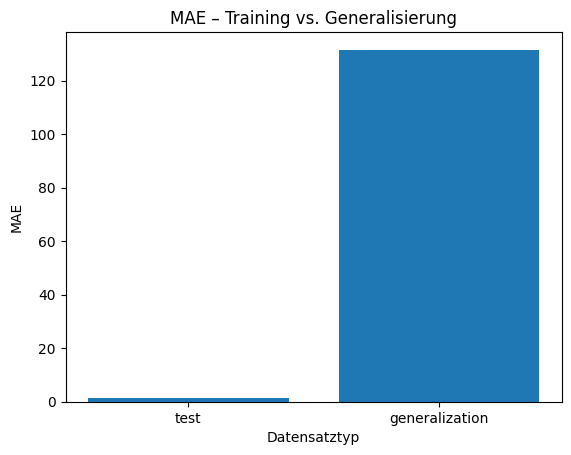

In [103]:
import matplotlib.pyplot as plt
subset = results[
    (results["model"] == "forest") 
]

plt.figure()
plt.bar(subset["dataset_type"], subset["mae"])
plt.title("MAE – Training vs. Generalisierung")
plt.xlabel("Datensatztyp")
plt.ylabel("MAE")
plt.show()


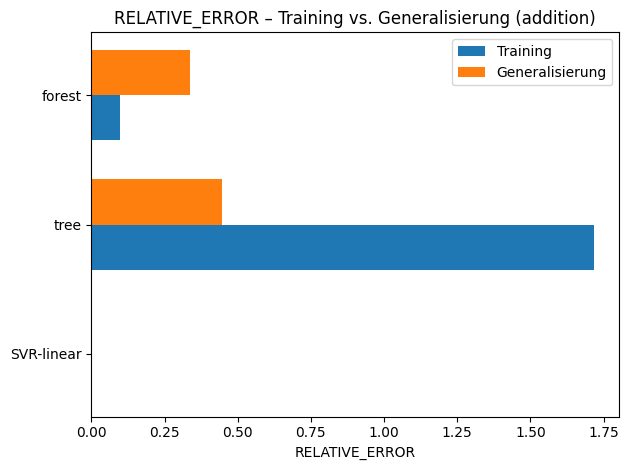

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# Filter: Operator und Metrik
operator = "addition"
metric = "relative_error"

subset = results[
    (results["operator"] == operator) &
    (results["dataset_type"].isin(["test", "generalization"]))
]

models = subset["model"].unique()
y_pos = np.arange(len(models))
bar_height = 0.35

train_values = []
gen_values = []

for model in models:
    train_values.append(
        subset[
            (subset["model"] == model) &
            (subset["dataset_type"] == "test")
        ][metric].values[0]
    )
    gen_values.append(
        subset[
            (subset["model"] == model) &
            (subset["dataset_type"] == "generalization")
        ][metric].values[0]
    )

plt.figure()
plt.barh(y_pos - bar_height/2, train_values, height=bar_height, label="Training")
plt.barh(y_pos + bar_height/2, gen_values, height=bar_height, label="Generalisierung")

plt.yticks(y_pos, models)
plt.xlabel(metric.upper())
plt.title(f"{metric.upper()} – Training vs. Generalisierung ({operator})")
plt.legend()
plt.tight_layout()
plt.show()
